### MOUNTING DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### IMPORT

In [ ]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

In [ ]:
os.system("pip install transformers")
os.system("pip install sentencepiece")
pass

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

### CONSTANTS

In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/SNAMA"

DATA_PATH = os.path.join(PROJECT_DIR, "data")
CHECKPOINTS_PATH = os.path.join(PROJECT_DIR, "checkpoints")
MODELS_PATH = os.path.join(PROJECT_DIR, "models")

PREPROCESSED_DATASET_NAME = "amazon_reviews_preprocessed.pckl"
PREPROCESSED_LABELS_NAME = "amazon_reviews_preprocessed_labels.pckl"

MODEL_HASHES_DATASET_NAME = "amazon_reviews_roberta_hashes.pckl"

In [ ]:
RANDOM_STATE = 0xd
TEST_SIZE = 0.3

In [ ]:
ROBERTA_FEATURES = 768
NUM_CLASSES = 0x3

In [ ]:
__LOGICAL_CORES__ = 0x4

In [ ]:
__DEVICE__ = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
__HASHES_FOUND__ = os.path.exists(os.path.join(DATA_PATH, MODEL_HASHES_DATASET_NAME))

### IO

In [ ]:
def dump_object(data, file, directory):
    with open(os.path.join(directory, file), 'wb') as file:
        pickle.dump(data, file)


def load_object(file, directory):
    with open(os.path.join(directory, file), 'rb') as file:
        data = pickle.load(file)
        return data


def exists_object(file, directory):
    return os.path.isfile(os.path.join(directory, file))


def dump_model(data, file, directory=MODELS_PATH):
    dump_object(data, file, directory)


def load_model(file, directory=MODELS_PATH):
    return load_object(file, directory)


def exists_model(file, directory=MODELS_PATH):
    return exists_object(file, directory)


def dump_checkpoint(data, file, directory=CHECKPOINTS_PATH):
    dump_object(data, file, directory)


def load_checkpoint(file, directory=CHECKPOINTS_PATH):
    return load_object(file, directory)


def exists_checkpoint(file, directory=CHECKPOINTS_PATH):
    return exists_object(file, directory)


def load_dataset_from_csv(file, directory=DATA_PATH):
    dataframe_ = pd.read_csv(os.path.join(directory, file))
    return dataframe_.Text.values, dataframe_.Score.values


def dump_dataset(data, file, directory=DATA_PATH):
    dump_object(data, file, directory)


def load_dataset(file, directory=DATA_PATH):
    return load_object(file, directory)


def exists_checkpoint(file, directory=DATA_PATH):
    return exists_object(file, directory)

### PREPROCESSED DATA LOADING

In [ ]:
if not __HASHES_FOUND__:
    dataset = load_dataset(PREPROCESSED_DATASET_NAME)
    labels = load_dataset(PREPROCESSED_LABELS_NAME)

### MODEL DEFINITION

In [ ]:
if not __HASHES_FOUND__:
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaModel.from_pretrained('roberta-base')

    for param in model.parameters():
        param.requires_grad = False

    model = model.cuda()

In [ ]:
if not __HASHES_FOUND__:
    print(model.config, "\n\n")
    print(tokenizer.pretrained_init_configuration)
    print(tokenizer.init_kwargs)

In [ ]:
class RobertaClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, features=ROBERTA_FEATURES):
        super(RobertaClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=features, out_features=512, bias=True),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(p=0.3),

            nn.Linear(in_features=512, out_features=128, bias=True),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.BatchNorm1d(64),
            nn.GELU(),

            nn.Linear(in_features=64, out_features=num_classes),
        )

    def forward(self, data):
        return self.classifier(data)

In [ ]:
classifier = RobertaClassifier(num_classes=NUM_CLASSES).to(__DEVICE__)

### COMPUTING DATASET HASHES

In [ ]:
if not __HASHES_FOUND__:
    hashes = []
    progress = '0'

    with torch.no_grad():
        for i in range(dataset.shape[0x0]):
            back = '\b' * len(progress)
            progress = str(i + 0x1)
            print(f"{back}{progress}", end="")
            data = tokenizer(dataset[i], truncation=True, return_tensors='pt').to(__DEVICE__)
            hashes.append(model(**data).pooler_output.cpu())
            del data
            torch.cuda.empty_cache()
    
    hashes_dataset = torch.stack(hashes).squeeze()
 
    dump_dataset(hashes_dataset, MODEL_HASHES_DATASET_NAME)

### HASHES LOADING

In [ ]:
class TextDataset(Dataset):

    def __init__(self, dataset_, labels_):
        if len(dataset_) != len(labels_):
            raise Exception("Mismatching Lens")

        self.dataset = dataset_
        self.labels = labels_
 

    def __len__(self):
        return len(self.dataset)

    
    def __getitem__(self, index):
        return (self.dataset[index], self.labels[index])

In [ ]:
hashes_dataset = load_dataset(MODEL_HASHES_DATASET_NAME)
labels = load_dataset(PREPROCESSED_LABELS_NAME)

In [ ]:
training_set, test_set, training_labels, test_labels = train_test_split(hashes_dataset,
                                                                        labels,
                                                                        test_size=TEST_SIZE,
                                                                        random_state=RANDOM_STATE)

In [ ]:
test_labels = torch.tensor(test_labels)

In [ ]:
training_dataset = TextDataset(training_set, training_labels)

In [ ]:
training_loader = DataLoader(dataset=training_dataset,
                             batch_size=0x40,
                             shuffle=True)

### OPTIMIZER & LOSS

In [ ]:
cross_entropy_loss = nn.CrossEntropyLoss()

In [ ]:
adam = torch.optim.Adam(classifier.parameters(), 
                        lr=2e-3)

### TRAINING

In [ ]:
def train(model, criterion, optimizer, loader, epochs, device=__DEVICE__):
    total_steps = len(loader)
    loss = 0.0
    min_loss = 0xffffffff
    
    best_weighs = None

    info = ""
    for epoch in range(1, epochs + 1):
        print("Epoch [{}/{}], Loss: {:1.4f}".format(epoch, epochs, loss))

        for batch_idx, (batch_data, batch_labels) in enumerate(loader):  
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            output = model(batch_data)

            loss = criterion(output, batch_labels)

            loss.backward()
            
            optimizer.step()
            if (batch_idx ) % 10 == 0:
                blanks = "\b" * (len(info))
                info = '\tStep [{}/{}], Loss: {:.4f}'.format(batch_idx, total_steps, loss.item())
                print("{}{}".format(blanks, info), end="")    
        
        if loss < min_loss:
            min_loss = loss
            best_weighs = model.state_dict()

        info = ""
        print("")

    return best_weighs

In [ ]:
best_params_50e = train(classifier, cross_entropy_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 1.1074	Step [10/2095], Loss: 0.7167	Step [20/2095], Loss: 0.7677	Step [30/2095], Loss: 0.8536	Step [40/2095], Loss: 0.8200	Step [50/2095], Loss: 0.9288	Step [60/2095], Loss: 0.8292	Step [70/2095], Loss: 0.6627	Step [80/2095], Loss: 0.7868	Step [90/2095], Loss: 0.7783	Step [100/2095], Loss: 0.8689	Step [110/2095], Loss: 0.8928	Step [120/2095], Loss: 0.8140	Step [130/2095], Loss: 0.8176	Step [140/2095], Loss: 0.8312	Step [150/2095], Loss: 0.8648	Step [160/2095], Loss: 0.8602

In [ ]:
best_params_100e = train(classifier, cross_entropy_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 0.3087	Step [10/2095], Loss: 0.2963	Step [20/2095], Loss: 0.3113	Step [30/2095], Loss: 0.2558	Step [40/2095], Loss: 0.4063	Step [50/2095], Loss: 0.3365	Step [60/2095], Loss: 0.2910	Step [70/2095], Loss: 0.2989	Step [80/2095], Loss: 0.2496	Step [90/2095], Loss: 0.2067	Step [100/2095], Loss: 0.2770	Step [110/2095], Loss: 0.3714	Step [120/2095], Loss: 0.2726	Step [130/2095], Loss: 0.4224	Step [140/2095], Loss: 0.4093	Step [150/2095], Loss: 0.2639	Step [160/2095], Loss: 0.1843

In [ ]:
best_params_150e = train(classifier, cross_entropy_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 0.1540	Step [10/2095], Loss: 0.2097	Step [20/2095], Loss: 0.1387	Step [30/2095], Loss: 0.0641	Step [40/2095], Loss: 0.1121	Step [50/2095], Loss: 0.2080	Step [60/2095], Loss: 0.1141	Step [70/2095], Loss: 0.2073	Step [80/2095], Loss: 0.1790	Step [90/2095], Loss: 0.2001	Step [100/2095], Loss: 0.1546	Step [110/2095], Loss: 0.2144	Step [120/2095], Loss: 0.2285	Step [130/2095], Loss: 0.2041	Step [140/2095], Loss: 0.1811	Step [150/2095], Loss: 0.2079	Step [160/2095], Loss: 0.1374

In [ ]:
checkpoint = classifier.state_dict()

### TEST

In [ ]:
def compute_accuracy(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
params = [best_params_50e, best_params_100e, best_params_150e]

with torch.no_grad():
    for i, param in enumerate(params):
        classifier.load_state_dict(param)
        test_pred = classifier(test_set.to(__DEVICE__)).cpu()
        acc = compute_accuracy(test_pred, test_labels)
        print("Checkpoint @{} epochs: {} accuracy".format((i + 0x1) * 50, acc))

Checkpoint @50 epochs: 74.0 accuracy
Checkpoint @100 epochs: 74.0 accuracy
Checkpoint @150 epochs: 74.0 accuracy


In [ ]:
__DUMP_WEIGHTS__ = False
if __DUMP_WEIGHTS__:
    torch.save(classifier.state_dict(), os.path.join(MODELS_PATH, "roberta_clf_150e_74a.pth"))

### PLOTS

In [ ]:
def plot_confusion_matrix(torch_model, data, true_labels, model_name, device=__DEVICE__):
    y_pred_softmax = torch.log_softmax(classifier(data.to(device)), dim=0x1)
    _, y_pred = torch.max(y_pred_softmax, dim=0x1)
    y_pred = y_pred.cpu()
    accuracy = accuracy_score(test_labels, y_pred)
    raw_confusion_matrix = confusion_matrix(test_labels, y_pred)
    display = ConfusionMatrixDisplay(raw_confusion_matrix, display_labels=np.unique(test_labels)).plot(cmap="Blues")
    display.ax_.set_title(f"{model_name} Confusion Matrix (Accuracy: {np.round(accuracy, 0x2)})")
    plt.show()

In [ ]:
classifier.load_state_dict(torch.load(os.path.join(MODELS_PATH, "roberta_clf_150e_74a.pth")))

<All keys matched successfully>

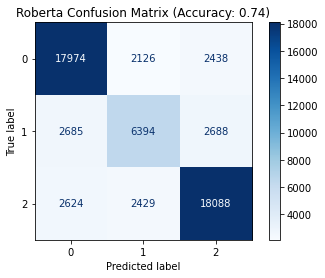

In [ ]:
plot_confusion_matrix(classifier, test_set, test_labels, "Roberta")

### WEIGHTED LOSS

In [ ]:
ins = (1.0 / torch.tensor([np.sum(training_labels == i) for i in range(NUM_CLASSES)])).to(__DEVICE__)

In [ ]:
classifier = RobertaClassifier(num_classes=NUM_CLASSES).to(__DEVICE__)

In [ ]:
cross_entropy_weighted_loss = nn.CrossEntropyLoss(weight=ins)

In [ ]:
adam = torch.optim.Adam(classifier.parameters(), 
                        lr=2e-3)

### TRAINING WEIGHTED

In [ ]:
best_weighted_params_50e = train(classifier, cross_entropy_weighted_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 1.1645	Step [10/2095], Loss: 1.0008	Step [20/2095], Loss: 0.9122	Step [30/2095], Loss: 0.8365	Step [40/2095], Loss: 1.0033	Step [50/2095], Loss: 0.8895	Step [60/2095], Loss: 0.8595	Step [70/2095], Loss: 0.8816	Step [80/2095], Loss: 1.0020	Step [90/2095], Loss: 0.8350	Step [100/2095], Loss: 0.9342	Step [110/2095], Loss: 0.8471	Step [120/2095], Loss: 0.7596	Step [130/2095], Loss: 0.8642	Step [140/2095], Loss: 0.8761	Step [150/2095], Loss: 0.8285	Step [160/2095], Loss: 0.9874

In [ ]:
best_weighted_params_100e = train(classifier, cross_entropy_weighted_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 0.3246	Step [10/2095], Loss: 0.3321	Step [20/2095], Loss: 0.2791	Step [30/2095], Loss: 0.2757	Step [40/2095], Loss: 0.2369	Step [50/2095], Loss: 0.3727	Step [60/2095], Loss: 0.4023	Step [70/2095], Loss: 0.2372	Step [80/2095], Loss: 0.2940	Step [90/2095], Loss: 0.2773	Step [100/2095], Loss: 0.3225	Step [110/2095], Loss: 0.2036	Step [120/2095], Loss: 0.1434	Step [130/2095], Loss: 0.3364	Step [140/2095], Loss: 0.2114	Step [150/2095], Loss: 0.1533	Step [160/2095], Loss: 0.1843

In [ ]:
best_weighted_params_150e = train(classifier, cross_entropy_weighted_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 0.1622	Step [10/2095], Loss: 0.1820	Step [20/2095], Loss: 0.1911	Step [30/2095], Loss: 0.2856	Step [40/2095], Loss: 0.1455	Step [50/2095], Loss: 0.2371	Step [60/2095], Loss: 0.1758	Step [70/2095], Loss: 0.1457	Step [80/2095], Loss: 0.3205	Step [90/2095], Loss: 0.2371	Step [100/2095], Loss: 0.2105	Step [110/2095], Loss: 0.2868	Step [120/2095], Loss: 0.1744	Step [130/2095], Loss: 0.2002	Step [140/2095], Loss: 0.3027	Step [150/2095], Loss: 0.2389	Step [160/2095], Loss: 0.2838

### TEST WEIGHTED

In [ ]:
params = [best_weighted_params_50e, best_weighted_params_100e, best_weighted_params_150e]

with torch.no_grad():
    for i, param in enumerate(params):
        classifier.load_state_dict(param)
        test_pred = classifier(test_set.to(__DEVICE__)).cpu()
        acc = compute_accuracy(test_pred, test_labels)
        print("Checkpoint @{} epochs: {} accuracy".format((i + 0x1) * 50, acc))

Checkpoint @50 epochs: 73.0 accuracy
Checkpoint @100 epochs: 73.0 accuracy
Checkpoint @150 epochs: 73.0 accuracy


In [ ]:
__DUMP_WEIGHTS__ = True
if __DUMP_WEIGHTS__:
    torch.save(classifier.state_dict(), os.path.join(MODELS_PATH, "roberta_clf_weighted_150e_73a.pth"))

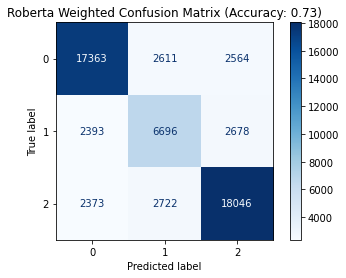

In [ ]:
plot_confusion_matrix(classifier, test_set, test_labels, "Roberta Weighted")